##  Test Chris facilitation-scheme on Aquila

In [1]:
import pandas as pd
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

tracker = Tracker().start()

check initial filling of Tweezers

In [2]:
from braket.aws import AwsQuantumTask
task = AwsQuantumTask(arn="arn:aws:braket:us-east-1:545821822555:quantum-task/12345")

C:\Users\marcel\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
task.result()
# first traj. has 3 unoccupied spaces of 75 => approx. 4% empty in init

AccessDeniedException: An error occurred (AccessDeniedException) when calling the GetQuantumTask operation: User: arn:aws:iam::813675479339:user/AnalogQuantumComputerTest is not authorized to access this resource

In [3]:
from braket.aws import AwsDevice
from pprint import pprint as pp

Aquila_device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = Aquila_device.properties.paradigm
pp(capabilities.dict())

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

In [4]:
lattice_constraints = capabilities.lattice
pp(lattice_constraints.dict())

{'area': {'height': Decimal('0.000076'), 'width': Decimal('0.000075')},
 'geometry': {'numberSitesMax': 256,
              'positionResolution': Decimal('1E-7'),
              'spacingRadialMin': Decimal('0.000004'),
              'spacingVerticalMin': Decimal('0.000004')}}


In [5]:
print(lattice_constraints.area.__doc__)
print(lattice_constraints.geometry.__doc__)


    The area of the FOV
    Attributes:
        width (Decimal): Largest allowed difference between x
            coordinates of any two sites (measured in meters)
        height (Decimal): Largest allowed difference between y
            coordinates of any two sites (measured in meters)
    

    Spacing or number of sites or rows
    Attributes:
        spacingRadialMin (Decimal): Minimum radial spacing between any
            two sites in the lattice (measured in meters)
        spacingVerticalMin (Decimal): Minimum spacing between any two
            rows in the lattice (measured in meters)
        positionResolution (Decimal): Resolution with which site positions
            can be specified (measured in meters)
        numberSitesMax (int): Maximum number of sites that can be placed
            in the lattice
    


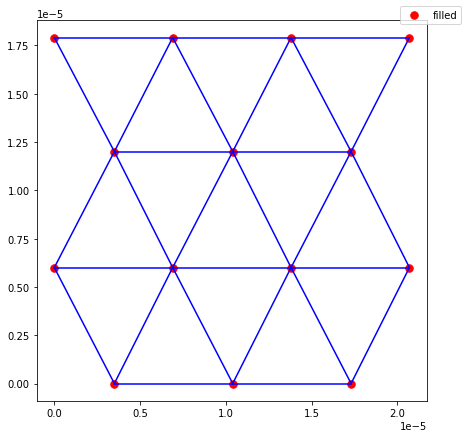

In [189]:
from decimal import Decimal
import numpy as np
from braket.ahs.atom_arrangement import AtomArrangement
from ahs_utils import show_register

Delta = Decimal('50000000.0')
blockade_radius = Decimal('0.000008')
separation = (capabilities.dict()['rydberg']['c6Coefficient'] / Delta) ** (Decimal(1) / Decimal(6))
max_width = lattice_constraints.dict()['area']['width']

dim_lattice = 3

N_atoms = 0
register = AtomArrangement()
for k in range(dim_lattice + 1):
    for m in range(dim_lattice + (k % 2)):
        register.add(
            (np.round(0.5 * float(separation) * ((k - 1) % 2) + m * float(separation), 7),
             np.round(k * float(separation) * np.sqrt(3) / 2, 7)))
        N_atoms += 1

show_register(register, show_atom_index=False, blockade_radius=float(blockade_radius))

In [190]:
rydberg = capabilities.rydberg
pp(rydberg.dict())

{'c6Coefficient': Decimal('5.42E-24'),
 'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                     Decimal('125000000.0')),
                   'detuningResolution': Decimal('0.2'),
                   'detuningSlewRateMax': Decimal('2500000000000000.0'),
                   'phaseRange': (Decimal('-99.0'), Decimal('99.0')),
                   'phaseResolution': Decimal('5E-7'),
                   'rabiFrequencyRange': (Decimal('0.0'),
                                          Decimal('15800000.0')),
                   'rabiFrequencyResolution': Decimal('400.0'),
                   'rabiFrequencySlewRateMax': Decimal('250000000000000.0'),
                   'timeDeltaMin': Decimal('5E-8'),
                   'timeMax': Decimal('0.000004'),
                   'timeMin': Decimal('0.0'),
                   'timeResolution': Decimal('1E-9')}}


In [191]:
print(rydberg.rydbergGlobal.__doc__)


    Parameters determining the limitations on the driving field that drives the
        ground-to-Rydberg transition uniformly on all atoms
    Attributes:
        rabiFrequencyRange (Tuple[Decimal,Decimal]): Achievable Rabi frequency
            range for the global Rydberg drive waveform (measured in rad/s)
        rabiFrequencyResolution (Decimal): Resolution with which global Rabi
            frequency amplitude can be specified (measured in rad/s)
        rabiFrequencySlewRateMax (Decimal): Maximum slew rate for changing the
            global Rabi frequency (measured in (rad/s)/s)
        detuningRange(Tuple[Decimal,Decimal]): Achievable detuning range for
            the global Rydberg pulse (measured in rad/s)
        detuningResolution(Decimal): Resolution with which global detuning can
            be specified (measured in rad/s)
        detuningSlewRateMax (Decimal): Maximum slew rate for detuning (measured in (rad/s)/s)
        phaseRange(Tuple[Decimal,Decimal]): Achievabl

In [227]:
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from ahs_utils import rabi_pulse, constant_time_series

omega_const = 1.5e7  # rad / s
rabi_pulse_area = np.pi  # rad
omega_slew_rate_max = float(rydberg.rydbergGlobal.rabiFrequencySlewRateMax)  # rad/s^2

time_points, amplitude_values = rabi_pulse(rabi_pulse_area, omega_const, 0.99 * omega_slew_rate_max)

amplitude = TimeSeries()
for t, v in zip(time_points, amplitude_values):
    amplitude.put(t, v)

detuning = constant_time_series(amplitude, float(Delta) * 0.5)
phase = constant_time_series(amplitude, 0.0)

drive = DrivingField(
    amplitude=amplitude,
    detuning=detuning,
    phase=phase
)

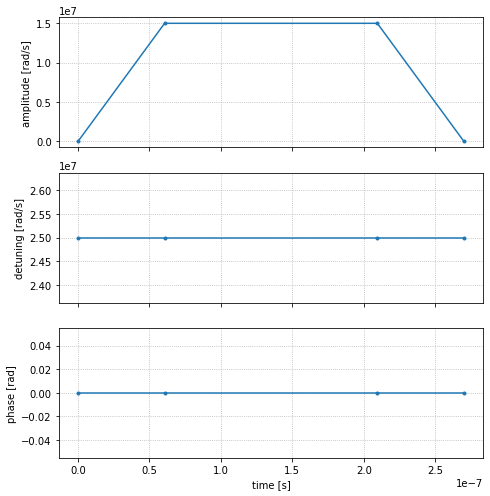

In [228]:
from ahs_utils import show_global_drive

show_global_drive(drive);

now start simulating

In [229]:
n_shots = 100

In [230]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register,
    hamiltonian=drive
)
discretized_ahs_program = ahs_program.discretize(Aquila_device)

NameError: name 'Aquila_device' is not defined

In [231]:
Aquila_device.properties.service.shotsRange

NameError: name 'Aquila_device' is not defined

change device to local simulator

In [232]:
from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

result = device.run(ahs_program, shots=n_shots).result()

In [233]:
result.measurements

[ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1])),
 ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([

In [234]:
from ahs_utils import get_counts

counts = get_counts(result)

num_ryd = np.zeros(N_atoms + 1)

for key, val in counts.items():
    amount_r_in_shot = 0
    for letter in key:
        if letter == 'r':
            amount_r_in_shot += 1

    num_ryd[amount_r_in_shot]  += val

num_ryd = num_ryd / n_shots

<BarContainer object of 15 artists>

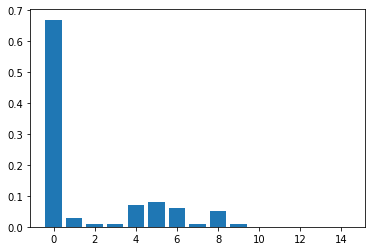

In [215]:
import matplotlib.pyplot as plt

plt.bar(np.arange(N_atoms + 1), num_ryd)

<BarContainer object of 15 artists>

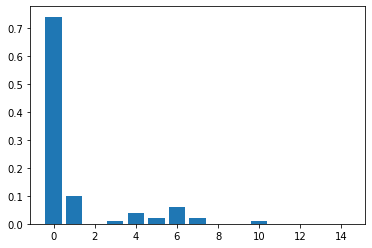

In [226]:
import matplotlib.pyplot as plt

plt.bar(np.arange(N_atoms + 1), num_ryd)

<BarContainer object of 15 artists>

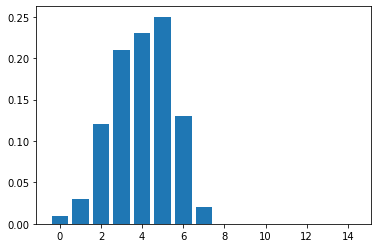

In [235]:
import matplotlib.pyplot as plt

plt.bar(np.arange(N_atoms + 1), num_ryd)

In [217]:
print("Task Summary")
print(tracker.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")

Task Summary
{'arn:aws:braket:us-east-1::device/qpu/quera/Aquila': {'shots': 100, 'tasks': {'CREATED': 1}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 1.30 USD
